This notebook is to plot figure 1 in the paper, and calculate the logN value using AODM for a sanity check. 

03/28/2019, YZ. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
import astropy.io.fits as fits
from yztools.vhelio2vlsr import vhelio2vlsr_Westmeier
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

from astroquery.simbad import Simbad
gal_simbad = Simbad.query_object('DDO221') # WLM = DDO221
coord = SkyCoord(ra=gal_simbad['RA'], dec=gal_simbad['DEC'], unit=(u.hourangle, u.degree))
wlm_l = coord.galactic.l.degree
wlm_b = coord.galactic.b.degree
wlm_ra = coord.icrs.ra.degree
wlm_dec = coord.icrs.dec.degree
print('l = %.4f deg, b = %.4f deg'%(wlm_l, wlm_b))
print('ra = %.4f deg, dec = %.4f deg'%(wlm_ra, wlm_dec))

l = 75.8532 deg, b = -73.6258 deg
ra = 0.4912 deg, dec = -15.4639 deg


### Generate Figure 1 

In [16]:
qso_simbad = Simbad.query_object('PHL2525')
coord = SkyCoord(ra=qso_simbad['RA'], dec=qso_simbad['DEC'], unit=(u.hourangle, u.degree))
ra = coord.icrs.ra
dec = coord.icrs.dec
vcorr = vhelio2vlsr_Westmeier(0, ra, dec)
print(coord.icrs)
print(coord.galactic)

<SkyCoord (ICRS): (ra, dec) in deg
    [(0.10173042, -12.76327889)]>
<SkyCoord (Galactic): (l, b) in deg
    [(80.68333325, -71.3171668)]>


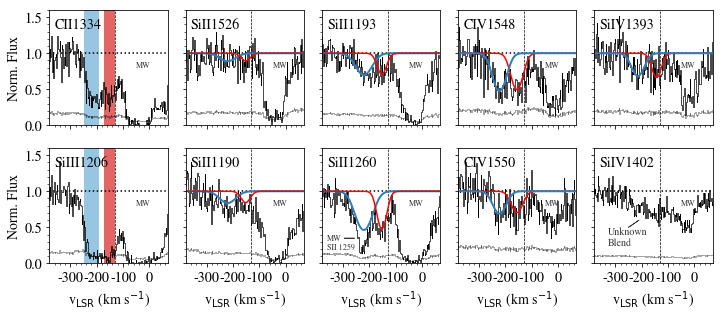

In [17]:
lines = ['CII1334', 'SiIII1206', 'SiII1526', 'SiII1190', 'SiII1193', 'SiII1260', 
         'CIV1548', 'CIV1550', 'SiIV1393', 'SiIV1402']
iz = -0.00044 # = 132/3e5 

fig, ((ax1, ax3, ax5, ax7, ax9), (ax2, ax4, ax6, ax8, ax10)) = plt.subplots(2, 5, sharex='col', 
                                                                  sharey='row', figsize=(10, 4.5))
i = 0
for iontag, ax in zip(lines, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]):
    thisf = 'data/cos_processed/linespec/PHL2525_%s.fits'%(iontag)
    
    spec = fits.getdata(thisf)
    vel = spec[0][9]+vcorr-130 # correct from vhelio to vlsr

    ax.step(vel, spec[0][14], color='k', linewidth=0.7)    # data, for xrange = -175, 175
    ax.step(vel, spec[0][16], color='k', alpha=0.6, linewidth=0.6)

    indtick = []
    if spec[0][17] != 0 and i not in [0, 1]:   
        # ax.plot(vel, spec[0][30], color='b', alpha=0.6, linewidth=1.5)
        if i in [2, 3, 4, 5]:
            ax.plot(vel, spec[0][18][:, 0], color=plt.cm.Blues(0.7), linewidth=2)
            ax.plot(vel, spec[0][18][:, 1], color='r', linewidth=1.5)
        else:
            ax.plot(vel, spec[0][18][:, 0], color='r', linewidth=1.5)
            ax.plot(vel, spec[0][18][:, 1], color=plt.cm.Blues(0.7), linewidth=2)
    ax.set_xticks(np.mgrid[-300:100:100])
    ax.set_xticklabels(['-300', '-200', '-100', '0'], fontsize=14)
    ax.set_xlim(-250-130, 200-130)
    ax.set_ylim(0, 1.6)
    ax.minorticks_on()
    ax.vlines(-130, 0, 1.6, linestyle='--', lw=0.7)
    ax.hlines(1.0, -250-130, 200-130, linestyle=':')
    ax.tick_params(labelsize=14)
    ax.text(-230-130, 1.35, iontag, fontsize=14)
    ax.text(-50, 0.8, 'MW', fontsize=8, alpha=0.8)
    
    if i%2 == 1:
        ax.set_xlabel(r'v$_{\rm LSR}$ (km s$^{-1}$)', fontsize=14)
    if i in [0, 1]:
        ax.set_ylabel('Norm. Flux', fontsize=14)
    i=i+1

# point out the containation in SiII1260
ax6.text(-360, 0.2, 'MW\nSII 1259', fontsize=8, alpha=0.8)
ax6.arrow(-255, 0.35, -40, 0, alpha=0.8, lw=0.7)

# point out SiIV blending 
ax10.text(-330, 0.25, 'Unknown\nBlend', fontsize=10, alpha=0.8)
ax10.arrow(-210, 0.6, -40, -0.1, alpha=0.8, lw=0.7)

# for CII 1334/SiIII1206 only 
ca_min, ca_max = -150.2-41/2., -150.2+41/2.
cb_min, cb_max = -218.7-58/2., -218.7+58/2.
for ax in [ax1, ax2]:
    ax.fill_between([ca_min, ca_max], 0, 1.6, edgecolor='none', 
                    facecolor=plt.cm.Reds(0.7), alpha=0.7)
    ax.fill_between([cb_min, cb_max], 0, 1.6, edgecolor='none', 
                    facecolor=plt.cm.Blues(0.5), alpha=0.7)
    
ax1.text
fig.tight_layout()
fig.savefig('figs/fig1_phl2525_coslines.pdf')

### logN from AODM for each line 

In [18]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np

def get_aodm(vel, spec, err, xl, xr, e_xl, e_xr, wave, fval):
    vel[np.isnan(vel)] = -10000
    ind = np.all([vel>=xl, vel<=xr], axis=0)
    ispec = spec[ind]
    ivel = vel[ind]
    ierr = err[ind]
    ispec[ispec<=0.] = 0.01
    # ierr[ierr<0.] = 0.01
    meandeltav = np.fabs((ivel.max()-ivel.min())/(len(ivel)-1))
    
    tau = -np.log(ispec)
    Ntot = np.fabs((3.768e14*tau/(wave*fval)*meandeltav).sum())
    
    # from cos-halos 
    tau_err = ierr/ispec
    Nsigma = np.sqrt(np.sum((3.768e14*tau_err/(wave*fval)*meandeltav)**2))
    
    return np.log10(Ntot), Nsigma/np.log(10)/Ntot

In [19]:
ca_min, ca_max = -150.2-41/2.+132, -150.2+41/2.+132
cb_min, cb_max = -218.7-58/2.+132, -218.7+58/2.+132

In [20]:
lines = ['CII1334', 'SiIII1206', 'SiII1526', 'SiII1190', 'SiII1193', 'SiII1260', 
         'CIV1548', 'CIV1550', 'SiIV1393', 'SiIV1402', 'OI1302', ]
waves = [1334.5323, 1206.5, 1526.7066, 1190.4158, 1193.2897, 1260.4221, 
         1548.2049, 1550.7785, 1393.7550, 1402.7700, 1302.1685]
fvals = [0.1278, 1.660E+00, 1.270E-01, 2.502E-01, 4.991E-01, 1.007E+00, 
         1.908E-01, 9.522E-02, 5.280E-01, 2.620E-01, 4.887E-02]

for i, iontag in enumerate(lines):
    thisf = 'data/cos_processed/linespec/PHL2525_%s.fits'%(iontag)
    
    spec = fits.getdata(thisf)
    vel = spec[0][9] # correct from vhelio to vlsr
    flux = spec[0][14]
    err = spec[0][16]

    a_logN, a_logNerr = get_aodm(vel, flux, err, ca_min, ca_max, ca_min, ca_max, 
                                 waves[i], fvals[i])
    b_logN, b_logNerr = get_aodm(vel, flux, err, cb_min, cb_max, cb_min, cb_max, 
                                 waves[i], fvals[i])
    print('%10s: (I) %.2f +/- %.2f; (II) %.2f+/-%.2f; %.2f'%(iontag, a_logN, a_logNerr, 
                                                             b_logN, b_logNerr, 
                                                             np.log10(10**a_logN+10**b_logN)))

   CII1334: (I) 13.93 +/- 0.04; (II) 14.07+/-0.03; 14.31
 SiIII1206: (I) 13.30 +/- 0.09; (II) 13.36+/-0.07; 13.63
  SiII1526: (I) 12.98 +/- 0.18; (II) 12.92+/-0.23; 13.25
  SiII1190: (I) 13.10 +/- 0.08; (II) 13.34+/-0.06; 13.54
  SiII1193: (I) 12.89 +/- 0.07; (II) 13.07+/-0.06; 13.29
  SiII1260: (I) 12.96 +/- 0.03; (II) 13.32+/-0.02; 13.48
   CIV1548: (I) 13.53 +/- 0.06; (II) 13.69+/-0.04; 13.92
   CIV1550: (I) 13.58 +/- 0.09; (II) 13.68+/-0.08; 13.93
  SiIV1393: (I) 12.81 +/- 0.08; (II) 12.94+/-0.07; 13.18
  SiIV1402: (I) 13.24 +/- 0.03; (II) 13.15+/-0.05; 13.50
    OI1302: (I) 13.24 +/- 0.25; (II) 13.24+/-0.30; 13.54
